In [101]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

## Full Architecture

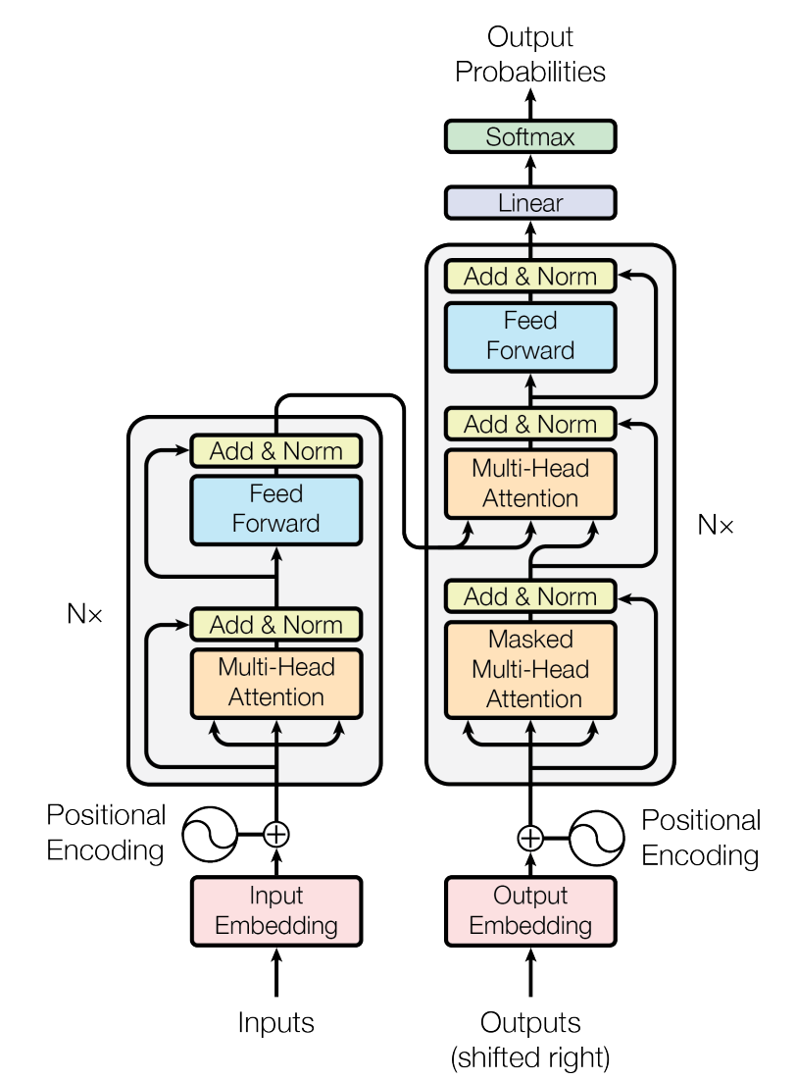

## 1. Encoder

### 1.1 Positional Encoding

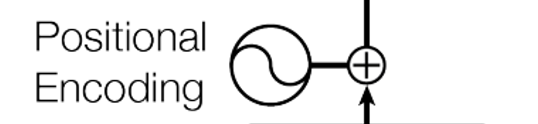

In [102]:
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, emb_size) -> None:
        super().__init__()
        # p: [seq_len, 1]
        p = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)
        # i: [1, emb_size/2]
        i = torch.arange(0, emb_size, 2, dtype=torch.float32).unsqueeze(0)
        # divisor: [seq_len, emb_size/2] by broadcasting
        divisor = p / 10000 ** (i / emb_size)
        # positional encoding: [seq_len, emb_size]
        pe = torch.zeros(seq_len, emb_size)
        # sin for even, cos for odd
        pe[:, 0::2] = torch.sin(divisor)
        pe[:, 1::2] = torch.cos(divisor)
        pe = pe.unsqueeze(0)
        # register as buffer so that it is saved in state_dict but not trained
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe



#### Visualizing Positional Encoding

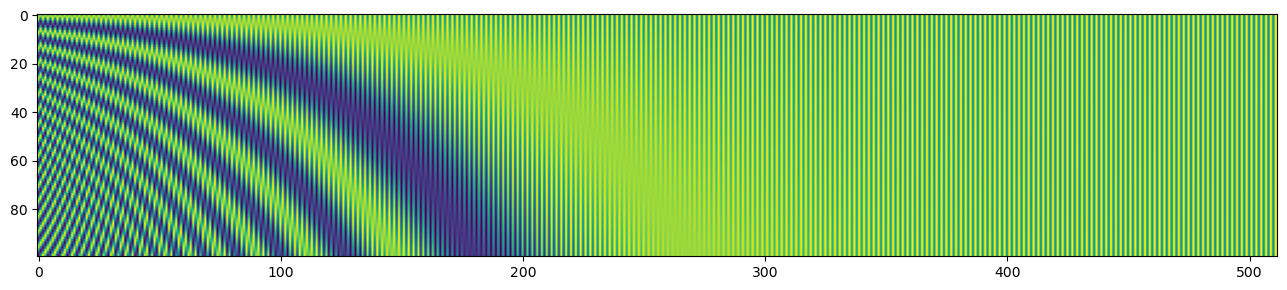

In [103]:
pe = PositionalEncoding(100, 512)
plt.figure(figsize=(16, 8))
plt.imshow(pe.pe.squeeze())

### 1.2 Multi-head Attention

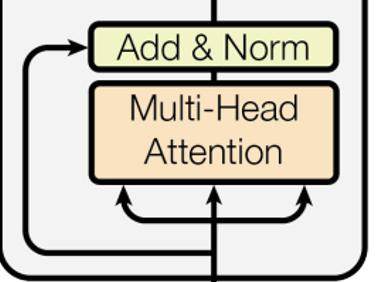

In [104]:
class MultiHeadAttention(nn.Module):

    def __init__(self, emb_size: int = 512, num_heads: int = 8) -> None:
        super().__init__()
        assert emb_size % num_heads == 0, "emb_size must be a multiple of num_heads" 
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_size = emb_size // self.num_heads

        # linear layers for query, key, value, and output
        self.w_q = nn.Linear(emb_size, emb_size)
        self.w_k = nn.Linear(emb_size, emb_size)
        self.w_v = nn.Linear(emb_size, emb_size)
        self.w_o = nn.Linear(emb_size, emb_size)

    def forward(self, q, k, v, mask=None):
        # query, key, value: [batch_size, seq_len, emb_size]
        # query, key, and value are the same for self-attention in the encoder
        bs, seq_len, emb_size = q.shape
        # linear transformation for query, key, and value
        q = self.w_q(q)
        k = self.w_k(k)
        v = self.w_v(v)
        # split query, key, and value into multiple heads
        # query, key, value: [batch_size, num_heads, seq_len, head_size]
        q = q.view(bs, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        k = k.view(bs, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        v = v.view(bs, seq_len, self.num_heads, self.head_size).transpose(1, 2)
        # scaled dot-product attention
        # scores: [batch_size, num_heads, seq_len, seq_len]
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_size ** 0.5)
        # mask out the scores for padding tokens
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        # attention: [batch_size, num_heads, seq_len, seq_len]
        attention = F.softmax(scores, dim=-1)
        # out: [batch_size, num_heads, seq_len, head_size]
        out = torch.matmul(attention, v)
        # concat heads
        # out: [batch_size, seq_len, emb_size]
        # contiguous() is needed for view(). it makes the memory layout of out to be the same as if it had been
        # view only works on contiguous tensors
        out = out.transpose(1, 2).contiguous().view(bs, seq_len, emb_size)
        # linear transformation for output
        out = self.w_o(out)
        return out




### 1.3 Feed Forward Network
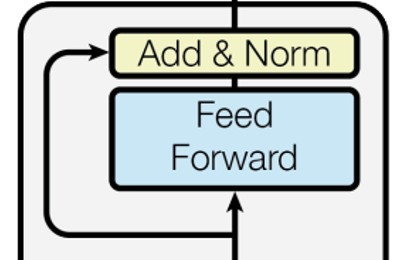

In [105]:
class FeedFowardNetwork(nn.Module):

    def __init__(self, emb_size: int = 512, ff_size: int = 2048) -> None:
        super().__init__()
        self.linear1 = nn.Linear(emb_size, ff_size)
        self.linear2 = nn.Linear(ff_size, emb_size)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

### 1.4 Encoder Layer


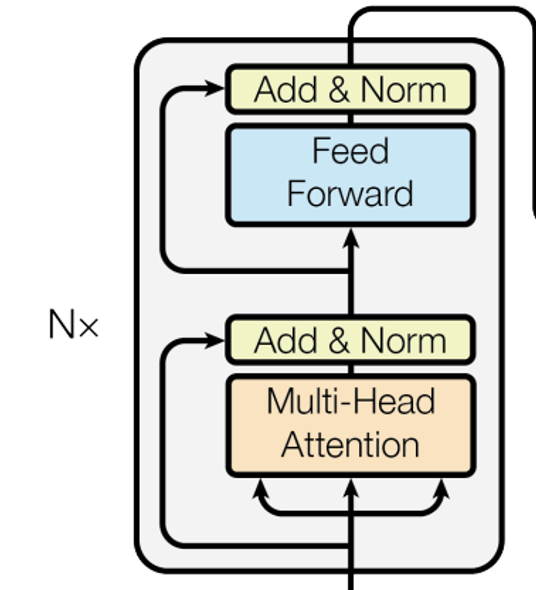

In [106]:
class EncoderLayer(nn.Module):

    def __init__(self,  emb_size: int = 512, num_heads: int = 8, ff_size: int = 2048, dropout: float = 0.1) -> None:
        super().__init__()
        self.attention = MultiHeadAttention(emb_size, num_heads)
        self.norm1 = nn.LayerNorm(emb_size)
        self.dropout1 = nn.Dropout(dropout)
        self.ff = FeedFowardNetwork(emb_size, ff_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # x: [batch_size, seq_len, emb_size]
        # self-attention
        # out: [batch_size, seq_len, emb_size]
        out = self.attention(x, x, x, mask)
        # residual connection and layer normalization
        out = self.norm1(x + self.dropout1(out))
        # feed forward
        # out: [batch_size, seq_len, emb_size]
        out = self.ff(out)
        # residual connection and layer normalization
        out = self.norm2(out + self.dropout2(out))
        return out

### 1.5 Encoder

In [107]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, seq_len, num_encs, emb_size, num_heads, ff_size, dropout) -> None:
        super().__init__()
        self.input_embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_encoding = PositionalEncoding(seq_len, emb_size)
        self.enc_layers = nn.ModuleList([EncoderLayer(emb_size, num_heads, ff_size, dropout) for _ in range(num_encs)])
        self.dropout = nn.Dropout(dropout)
    
    
    def forward(self, x, mask=None):
        # x: [batch_size, seq_len] -> [batch_size, seq_len, emb_size] 
        x = self.input_embedding(x)
        # x: [batch_size, seq_len, emb_size]
        x = self.pos_encoding(x)
        # x: [batch_size, seq_len, emb_size]
        x = self.dropout(x)
        for enc_layer in self.enc_layers:
            x = enc_layer(x, mask)
        return x
        

### 2. Decoder

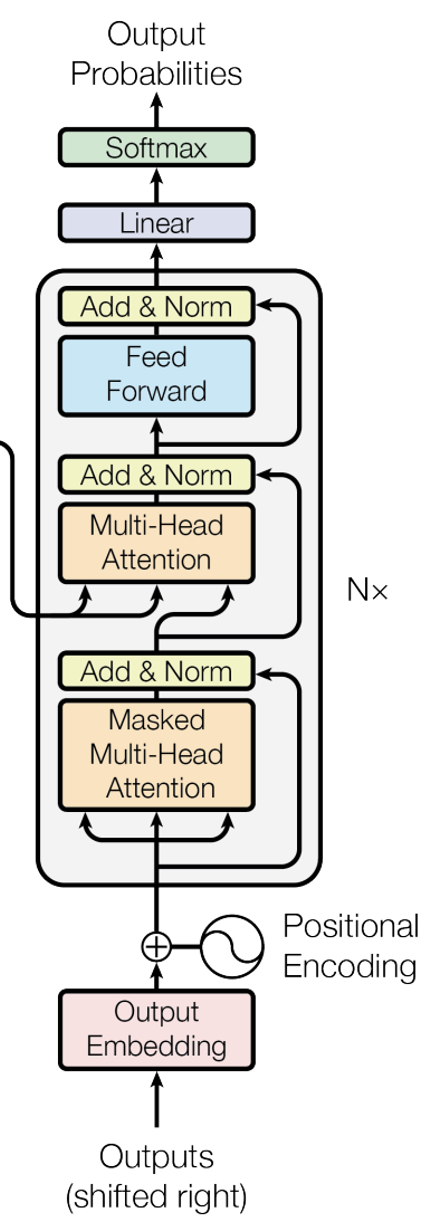

### 2.1 Decoder Layer

In [123]:
class DecoderLayer(nn.Module):

    def __init__(self, emb_size: int = 512, num_heads: int = 8, ff_size: int = 2048, dropout: float = 0.1) -> None:
        super().__init__()
        self.self_attention = MultiHeadAttention(emb_size, num_heads)
        self.norm1 = nn.LayerNorm(emb_size)
        self.cross_attention = MultiHeadAttention(emb_size, num_heads)
        self.norm2 = nn.LayerNorm(emb_size)
        self.ff = FeedFowardNetwork(emb_size, ff_size)
        self.norm3 = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, enc_mask=None, dec_mask=None) -> None:
        self_attn = self.self_attention(x, x, x, dec_mask)
        x = self.norm1(x + self.dropout(self_attn))
        cross_attn = self.cross_attention(x, enc_out, enc_out, enc_mask)
        x = self.norm2(x + self.dropout(cross_attn))
        ffo = self.ff(x)
        x = self.norm3(x + self.dropout(ffo))
        return x

### 2.2 Decoder

In [124]:
class Decoder(nn.Module):

    def __init__(self, vocab_size, seq_len, num_decs, emb_size, num_heads, ff_size, dropout):
        super().__init__()
        self.out_embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_encoding = PositionalEncoding(seq_len, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.dec_layers = nn.ModuleList([DecoderLayer(emb_size, num_heads, ff_size, dropout) for _ in range(num_decs)])
    

    def forward(self, x, enc_out, enc_mask=None, dec_mask=None):
        x = self.out_embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for dec in self.dec_layers:
            x = dec(x, enc_out, enc_mask, dec_mask)
        return x

### 3. Transformer

In [125]:
class Transformer(nn.Module):

    def __init__(self, 
                 src_vocab_size: int, 
                 trg_vocab_size: int, 
                 pad_token_idx: int,
                 seq_len: int, 
                 num_encs: int, 
                 num_decs: int, 
                 emb_size: int, 
                 num_heads: int, 
                 ff_size: int, 
                 dropout: float):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, seq_len, num_encs, emb_size, num_heads, ff_size, dropout)
        self.decoder = Decoder(trg_vocab_size, seq_len, num_decs, emb_size, num_heads, ff_size, dropout)
        self.out_linear = nn.Linear(emb_size, trg_vocab_size)
        self.pad_token_idx = pad_token_idx
    
    def create_masks(self, src, trg):
        batch_size, seq_len = src.shape
        # [batch_size, 1, 1, seq_len]
        enc_mask = (src != self.pad_token_idx).unsqueeze(1).unsqueeze(2)
        # [batch_size, 1, seq_len, 1]
        dec_pad_mask = (trg != self.pad_token_idx).unsqueeze(1).unsqueeze(3)
        # [seq_len, seq_len]
        look_ahead_mask = torch.tril(torch.ones(seq_len, seq_len)).bool()
        # [batch_size, 1, seq_len, seq_len]
        dec_mask = dec_pad_mask & look_ahead_mask
        return enc_mask, dec_mask

    def forward(self, enc_input, dec_input):
        enc_mask, dec_mask = self.create_masks(enc_input, dec_input)
        enc_out = self.encoder(enc_input, enc_mask)
        dec_out = self.decoder(dec_input, enc_out, enc_mask, dec_mask)
        out = self.out_linear(dec_out)
        return out

In [126]:
model = Transformer(src_vocab_size=13000, 
                    trg_vocab_size=13000, 
                    pad_token_idx=0, 
                    seq_len=100, 
                    num_encs=6, 
                    num_decs=6, 
                    emb_size=512, 
                    num_heads=8, 
                    ff_size=2048, 
                    dropout=0.1)

In [127]:
enc_input = torch.randint(0, 13000, (64, 100))
dec_input = torch.randint(0, 13000, (64, 100))

In [128]:
out = model(enc_input, dec_input)

In [130]:
out.shape

torch.Size([64, 100, 13000])

In [31]:
import torch
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

In [54]:
q = torch.randn((4, 8))
k = torch.randn((4, 8))
v = torch.randn((4, 8))
attn_score = q @ k.T * 4**(-0.5)
attn_score = F.softmax(attn_score, dim=-1)
attn_score

tensor([[0.0095, 0.0653, 0.0940, 0.8313],
        [0.6150, 0.2060, 0.1053, 0.0738],
        [0.1640, 0.5909, 0.0735, 0.1716],
        [0.0850, 0.4615, 0.0481, 0.4054]])

In [55]:
v

tensor([[ 2.3082,  0.5131,  2.5401,  0.4559,  0.1819, -0.5730, -0.0862,  0.5372],
        [-1.0041, -0.6406, -0.9038, -0.1609, -0.7373,  1.5886,  0.2697,  0.3843],
        [ 0.0583,  1.3628, -0.4981,  2.0925,  0.0937, -1.9461,  0.4099,  1.9081],
        [ 0.2908,  1.0894, -1.1923,  0.4973, -0.6675,  0.2441, -1.5816,  1.3753]])

In [56]:
attn_score @ v

tensor([[ 0.2036,  0.9967, -1.0727,  0.6039, -0.5924,  0.1182, -1.2594,  1.3527],
        [ 1.2403,  0.4074,  1.2356,  0.5042, -0.0794, -0.2120, -0.0710,  0.7119],
        [-0.1605, -0.0072, -0.3586,  0.2188, -0.5135,  0.7435, -0.0961,  0.6914],
        [-0.1466,  0.2552, -0.7086,  0.2667, -0.5909,  0.6898, -0.5043,  0.8723]])

In [37]:
attn_score

tensor([[    0.2834,     0.1895,     0.0049,     0.0028,     0.1673,     0.3388,
             0.0114,     0.0020],
        [    0.0128,     0.0001,     0.0000,     0.8528,     0.0299,     0.0024,
             0.1018,     0.0002],
        [    0.0027,     0.0000,     0.0000,     0.9779,     0.0001,     0.0015,
             0.0179,     0.0000],
        [    0.0054,     0.0173,     0.8173,     0.0017,     0.1056,     0.0034,
             0.0271,     0.0222],
        [    0.0002,     0.0000,     0.0000,     0.0004,     0.9739,     0.0012,
             0.0244,     0.0000],
        [    0.0003,     0.0000,     0.0000,     0.9740,     0.0042,     0.0000,
             0.0214,     0.0000],
        [    0.2755,     0.6647,     0.0000,     0.0000,     0.0105,     0.0491,
             0.0000,     0.0002],
        [    0.0000,     0.9721,     0.0003,     0.0000,     0.0000,     0.0030,
             0.0000,     0.0245]])